# Prototyping

In [ ]:
%matplotlib widget
from bmcs_beam.tension import RestrainedCrackingTestModel
from ibvpy.tmodel.mats2D import MATS2DScalarDamage
import numpy as np

In [ ]:
E_modulus = 30000
f_ct = 3.3

def new_bt(L, H, B, a, w_max=0.1, n_steps=50):
    kappa_0 = f_ct / E_modulus
    bt = RestrainedCrackingTestModel(material_model='scalar damage', 
                          n_e_x=3, n_e_y=30, w_max=w_max, k_max=1000)
    bt.time_line.step=float(1/n_steps)
    bt.history.warp_factor=100
    bt.cross_section.trait_set(B=B)
    bt.geometry.trait_set(L=L, H=H, a=a, L_cb=1);
    bt.material_model_.trait_set(E = E_modulus, nu = 0.2) # note nu = 0.0 to avoid compressive failure
    bt.material_model_.omega_fn = 'exp-slope'
    bt.material_model_.omega_fn_.trait_set(kappa_0=kappa_0, kappa_f=1.36)
#    bt.material_model_.omega_fn_.trait_set(kappa_0=kappa_0, kappa_f=0.0336)
    bt.material_model_.omega_fn = 'weibull-CDF'
    bt.material_model_.omega_fn_.trait_set(lambda_=0.00015, m=0.4)
    bt.material_model_.trait_set(D_alg=0.5, eps_max=0.1);
    return bt

In [ ]:
eps = 0.0002
L = 1500
bt = new_bt(L = L, H=3000, B=100, a=100, w_max=eps*L, n_steps=20)
bt.run()

In [ ]:
bt.interact()

Aspect ratio
$$
\chi = \frac{L}{H}
$$

The ratio between the initial crack length $a_0$ and the height $H$
$$
 \alpha_0 = \frac{a_0}{H}
$$

$$
\hat{w} = \mathrm{argmax}_{w > 0}(F(w))
$$

$$
\hat{F} = F(\hat{w})
$$

Remote failure stress 
$$
\hat{\sigma} = \frac{\hat{F}}{B H}
$$

$$
\hat{\varepsilon} = \frac{\hat{w}}{L}
$$

$$
\Delta T = \frac{\hat{\varepsilon}}{\alpha}
$$

Stress concentration factor
$$
\gamma_\mathrm{c}
=
\frac{\hat{\sigma}}{f_\mathrm{t}}
$$

Run a parametric study for $\alpha_0 \in (0, 1)$ 

In [ ]:
bt_dict = {}

In [ ]:
import numpy as np
a_0 = 200
H_factors = np.array([4, 6, 8])
L_factors = np.array([4, 6, 8, 16])
B = 230
eps_max = 0.0002
H_grid, L_grid = np.meshgrid(L_list, H_list)
bt_grid = np.zeros_like(H_grid, dtype=object)
for i, H_factor in enumerate(H_factors):
    for j, L_factor in enumerate(L_factors):
        key = (H_factor, L_factor)
        H = H_factor * a_0
        L = L_factor * a_0
        bt = bt_dict.get(key, None)
        if bt is None:
            print('calculating for H_factor = %g, L_factor = %g' % key)
            w_max = eps_max * L
            bt = new_bt(L=L, H=H, B=B, a=a_0, w_max=w_max, n_steps=20)
            try: 
                bt.run()
            except StopIteration:
                print('simulation interupted due to slow convergence', key)
        bt_grid[i, j] = bt
        bt_dict[key] = bt

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
colors = ['green', 'orange', 'blue', 'brown']
fig, (ax, ax_G) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)
ax_F = ax_G.twinx()
fig.canvas.header_visible=False
for i, H_factor in enumerate(H_factors):
    G_argmax_list, U_bar_argmax_list, sig_max_list = [], [], []
    for j, L_factor in enumerate(L_factors):
        key = (H_factor, L_factor)
        H = H_factor * a_0
        L = L_factor * a_0
        F, w = bt_grid[i, j].hist['Fw'].Fw
        argmax_F_w = np.argmax(F)
        A = bt_grid[i, j].cross_section.B * H
        eps, sig = w/L, F/A
        ax.plot(eps, sig, label='H_f = %g, L_f = %g' % (H, L), color=colors[i])
        G_argmax_list.append(bt_grid[i, j].hist['energy'].G_t[argmax_F_w])
        U_bar_argmax_list.append(bt_grid[i, j].hist['energy'].U_bar_t[argmax_F_w])
        sig_max_list.append(np.max(sig))
    ax_G.plot(L_factors, np.array(G_argmax_list)/np.array(U_bar_argmax_list), 
              color=colors[i], marker='H', linestyle='dashed')
    ax_F.plot(L_factors, np.array(sig_max_list), marker='H', color=colors[i], label=r'$H_f$ = %g' % H_factor);

#ax.legend()
ax.set_xlabel(r'$\varepsilon$ [-]');
ax.set_ylabel(r'$\sigma$ [MPa]');
ax_F.legend(loc=5)
ax_F.set_ylabel(r'$\sigma_\max$ [MPa]');
ax_G.set_ylabel(r'$G_f / U$ [-]');
ax_G.set_xlabel(r'$L_f$ [-]');

# Study 100 / 80

$a_0 = 100$ mm, 
$B = 80$ mm
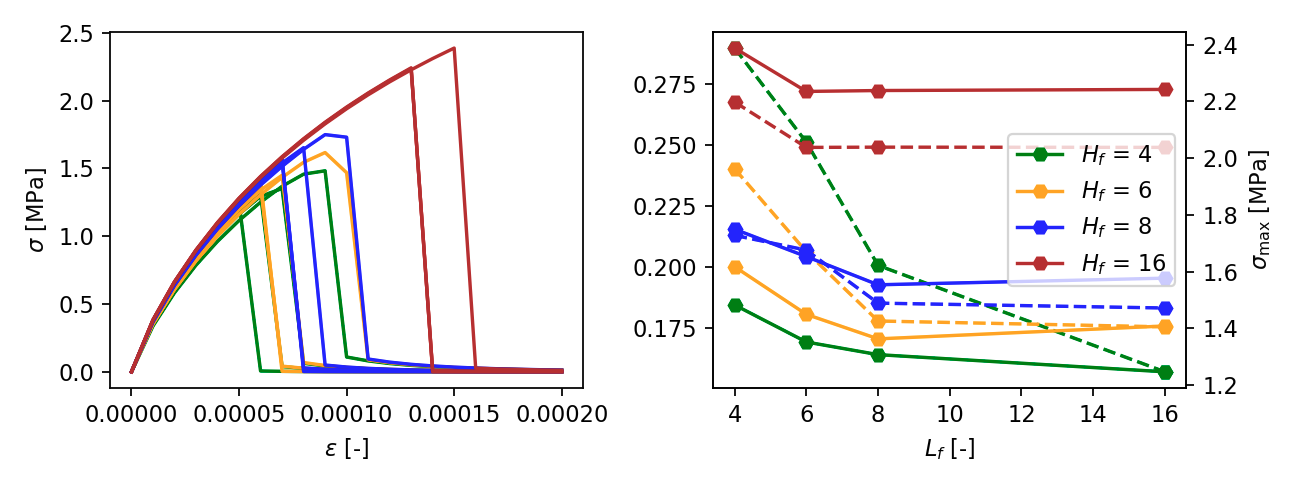


# Study 100 / 300

$a_0 = 100$ mm, 
$B = 300$ mm
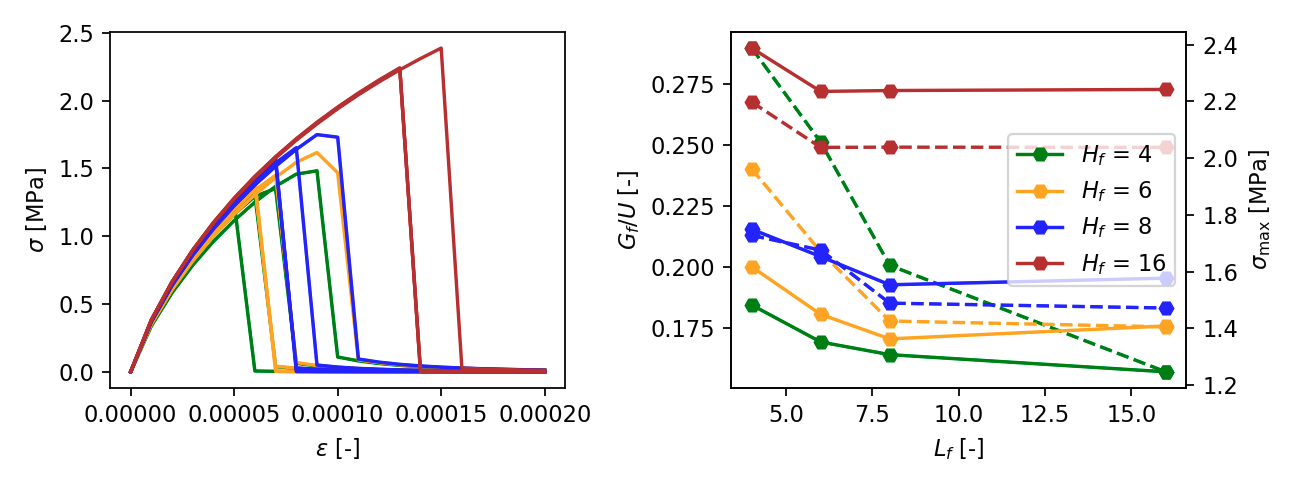

# Study 200 / 80

$a_0 = 200$ mm, 
$B = 80$ mm
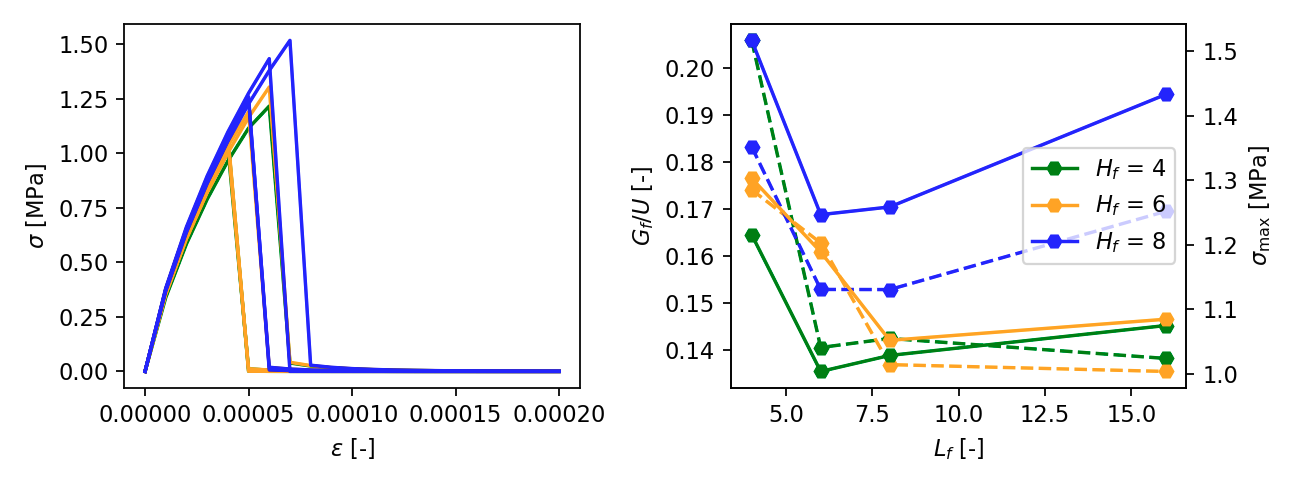

# Study 200 / 230

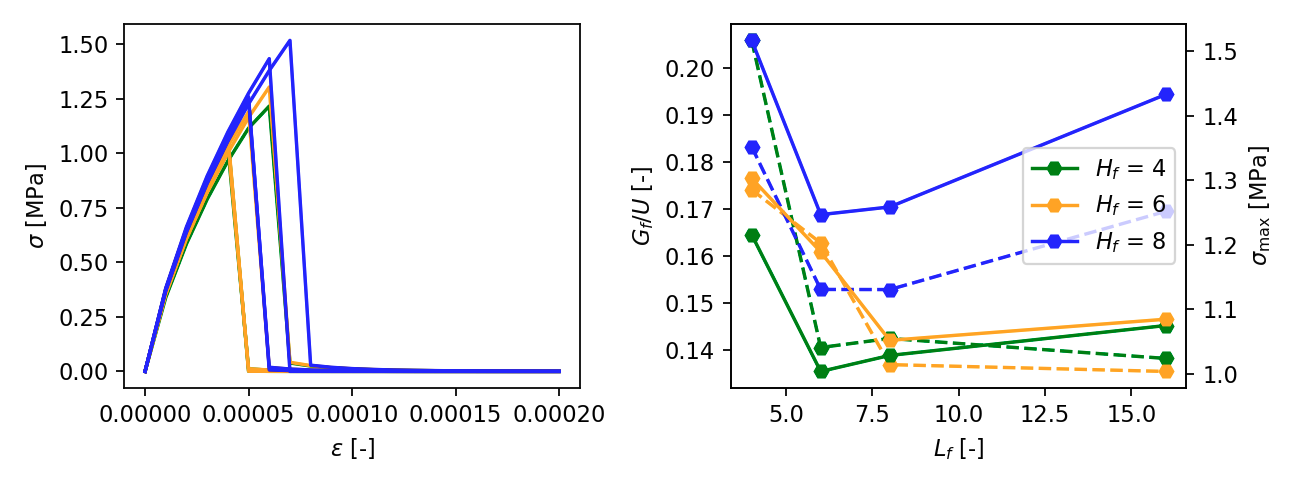